<a href="https://colab.research.google.com/github/sudiptawipro/EVA/blob/main/Session_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# Added sudipta
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


CUDA Available? True


CODE BLOCK: 3

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,))
    ])

CODE BLOCK: 4

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 103012679.06it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 98805623.02it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26648677.36it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3475105.58it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

In [ ]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(train_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

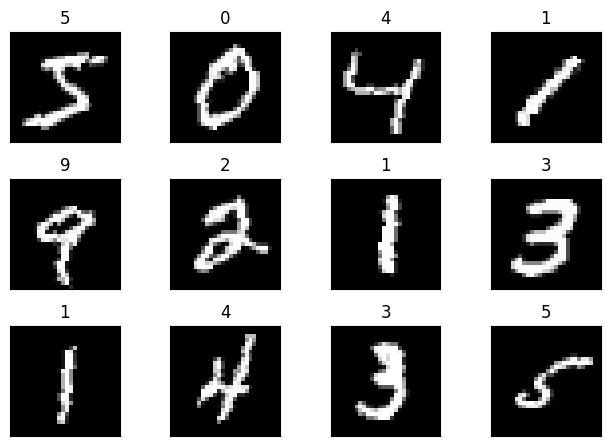

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [ ]:
batch_data, batch_label = next(iter(train_loader)) 
print(batch_data.shape)
print(batch_label.shape)

torch.Size([512, 1, 28, 28])
torch.Size([512])


In [ ]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3,bias=False)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,bias=False)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,bias=False)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3,bias=False)
        self.fc1 = nn.Linear(4096, 50,bias=False) # Changed Sudipta
        self.fc2 = nn.Linear(50, 10,bias=False)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) 
        x = F.relu(self.conv3(x), 2)
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) 
      
        x = x.view(-1, 4096) # Changed Sudipta
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 8

In [ ]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

CODE BLOCK: 9

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 3

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, train_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


  0%|          | 0/118 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f36ac231b40>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f36ac231b40>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d45094e0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509760>


Train: Loss=2.3034 Batch_id=3 Accuracy=10.21:   3%|▎         | 3/118 [00:01<00:40,  2.85it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d45090d0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e5fd0>


Train: Loss=2.3048 Batch_id=5 Accuracy=10.51:   4%|▍         | 5/118 [00:01<00:30,  3.71it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466fc90>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e68e0>


Train: Loss=2.2994 Batch_id=7 Accuracy=10.35:   6%|▌         | 7/118 [00:02<00:25,  4.28it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6f70>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6e30>


Train: Loss=2.2963 Batch_id=9 Accuracy=10.55:   8%|▊         | 9/118 [00:02<00:23,  4.69it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6f70>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466fc90>


Train: Loss=2.2977 Batch_id=11 Accuracy=10.19:   9%|▉         | 11/118 [00:02<00:21,  4.94it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e7060>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6fc0>


Train: Loss=2.2921 Batch_id=13 Accuracy=10.10:  11%|█         | 13/118 [00:03<00:20,  5.14it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d460a840>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6f20>


Train: Loss=2.2868 Batch_id=15 Accuracy=9.94:  13%|█▎        | 15/118 [00:03<00:19,  5.36it/s] 

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6fc0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6fc0>


Train: Loss=2.2805 Batch_id=17 Accuracy=10.60:  14%|█▍        | 17/118 [00:03<00:18,  5.48it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466ee30>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e68e0>


Train: Loss=2.2716 Batch_id=19 Accuracy=11.39:  16%|█▌        | 19/118 [00:04<00:18,  5.40it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6fc0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6ed0>


Train: Loss=2.2650 Batch_id=21 Accuracy=12.73:  18%|█▊        | 21/118 [00:04<00:18,  5.31it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6fc0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f3604d8ec50>


Train: Loss=2.2564 Batch_id=23 Accuracy=13.81:  19%|█▉        | 23/118 [00:04<00:17,  5.51it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f3604d8ec50>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e74c0>


Train: Loss=2.2434 Batch_id=25 Accuracy=14.40:  21%|██        | 25/118 [00:05<00:20,  4.64it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e7150>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6c00>


Train: Loss=2.2236 Batch_id=27 Accuracy=14.91:  23%|██▎       | 27/118 [00:05<00:18,  4.89it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f36008c28e0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e74c0>


Train: Loss=2.2048 Batch_id=29 Accuracy=15.35:  25%|██▍       | 29/118 [00:06<00:23,  3.84it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6fc0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f36008c28e0>


Train: Loss=2.1712 Batch_id=31 Accuracy=16.12:  26%|██▋       | 31/118 [00:07<00:23,  3.68it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d46946d0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6f20>


Train: Loss=2.1203 Batch_id=33 Accuracy=16.95:  29%|██▉       | 34/118 [00:07<00:20,  4.07it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6fc0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6c50>


Train: Loss=2.0326 Batch_id=35 Accuracy=18.32:  31%|███       | 36/118 [00:08<00:21,  3.79it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466cf40>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466fbf0>


Train: Loss=1.9226 Batch_id=37 Accuracy=19.88:  32%|███▏      | 38/118 [00:08<00:18,  4.31it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466c5e0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44c0e50>


Train: Loss=1.7392 Batch_id=39 Accuracy=21.57:  33%|███▎      | 39/118 [00:09<00:18,  4.33it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d464ef20>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466c130>


Train: Loss=1.4582 Batch_id=41 Accuracy=23.47:  36%|███▌      | 42/118 [00:09<00:13,  5.50it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466cfe0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f36008c1350>


Train: Loss=1.2198 Batch_id=43 Accuracy=25.45:  37%|███▋      | 44/118 [00:09<00:13,  5.55it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466cfe0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466cfe0>


Train: Loss=0.9909 Batch_id=44 Accuracy=26.33:  38%|███▊      | 45/118 [00:10<00:13,  5.42it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466c5e0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466cfe0>


Train: Loss=2.9379 Batch_id=47 Accuracy=27.88:  41%|████      | 48/118 [00:10<00:12,  5.66it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44bd1c0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466cfe0>


Train: Loss=6.5839 Batch_id=49 Accuracy=28.18:  42%|████▏     | 49/118 [00:11<00:14,  4.89it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466cf40>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466fbf0>


Train: Loss=2.2053 Batch_id=51 Accuracy=28.43:  43%|████▎     | 51/118 [00:11<00:13,  4.86it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44bc4a0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e68e0>


Train: Loss=2.2832 Batch_id=53 Accuracy=27.88:  45%|████▍     | 53/118 [00:12<00:16,  3.94it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6e80>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6fc0>


Train: Loss=2.2936 Batch_id=55 Accuracy=27.29:  47%|████▋     | 55/118 [00:12<00:14,  4.49it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e7060>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6ac0>


Train: Loss=2.2959 Batch_id=57 Accuracy=26.74:  48%|████▊     | 57/118 [00:12<00:12,  4.71it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6ac0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6e80>


Train: Loss=2.2984 Batch_id=59 Accuracy=26.22:  50%|█████     | 59/118 [00:13<00:11,  5.00it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44c0310>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e7060>


Train: Loss=2.2979 Batch_id=61 Accuracy=25.73:  52%|█████▏    | 61/118 [00:13<00:10,  5.31it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6020>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e5b70>


Train: Loss=2.2975 Batch_id=63 Accuracy=25.33:  54%|█████▍    | 64/118 [00:13<00:08,  6.11it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4695b20>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44bc4a0>


Train: Loss=2.2929 Batch_id=65 Accuracy=25.00:  56%|█████▌    | 66/118 [00:14<00:08,  5.91it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f360094ffb0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6f20>


Train: Loss=2.2958 Batch_id=67 Accuracy=24.64:  58%|█████▊    | 68/118 [00:14<00:08,  5.71it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6c50>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e5b70>


Train: Loss=2.2911 Batch_id=69 Accuracy=24.27:  59%|█████▉    | 70/118 [00:14<00:08,  5.76it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e60c0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e5b70>


Train: Loss=2.2949 Batch_id=70 Accuracy=24.07:  60%|██████    | 71/118 [00:15<00:08,  5.53it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e5b70>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6e80>


Train: Loss=2.2928 Batch_id=73 Accuracy=23.53:  63%|██████▎   | 74/118 [00:15<00:07,  5.80it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e7420>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6a20>


Train: Loss=2.2929 Batch_id=74 Accuracy=23.36:  64%|██████▎   | 75/118 [00:15<00:07,  5.54it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e7420>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e68e0>


Train: Loss=2.2871 Batch_id=76 Accuracy=23.13:  65%|██████▌   | 77/118 [00:16<00:07,  5.74it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e60c0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6e80>


Train: Loss=2.2835 Batch_id=78 Accuracy=22.91:  67%|██████▋   | 79/118 [00:16<00:06,  5.85it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6e80>


Train: Loss=2.2863 Batch_id=80 Accuracy=22.70:  68%|██████▊   | 80/118 [00:16<00:07,  5.17it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e5b70>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6e80>


Train: Loss=2.2768 Batch_id=82 Accuracy=22.63:  69%|██████▉   | 82/118 [00:17<00:06,  5.25it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e7060>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e7060>


Train: Loss=2.2746 Batch_id=84 Accuracy=22.49:  71%|███████   | 84/118 [00:17<00:06,  5.25it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6f20>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6ed0>


Train: Loss=2.2666 Batch_id=86 Accuracy=22.37:  73%|███████▎  | 86/118 [00:17<00:05,  5.40it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e7010>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e5b70>


Train: Loss=2.2645 Batch_id=88 Accuracy=22.24:  75%|███████▍  | 88/118 [00:18<00:05,  5.39it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466ee80>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e5b70>


Train: Loss=2.2508 Batch_id=90 Accuracy=22.17:  76%|███████▋  | 90/118 [00:18<00:05,  5.33it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4697560>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6fc0>


Train: Loss=2.2524 Batch_id=92 Accuracy=22.11:  78%|███████▊  | 92/118 [00:19<00:05,  4.90it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466fd30>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e68e0>


Train: Loss=2.2400 Batch_id=94 Accuracy=22.06:  80%|███████▉  | 94/118 [00:19<00:05,  4.57it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44be0c0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6d90>


Train: Loss=2.2316 Batch_id=96 Accuracy=22.00:  81%|████████▏ | 96/118 [00:20<00:05,  4.21it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6d90>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e5b70>


Train: Loss=2.2183 Batch_id=98 Accuracy=21.97:  83%|████████▎ | 98/118 [00:20<00:04,  4.11it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4695ee0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6b60>


Train: Loss=2.2153 Batch_id=100 Accuracy=21.94:  85%|████████▍ | 100/118 [00:21<00:04,  3.76it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6c50>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466f740>


Train: Loss=2.1723 Batch_id=102 Accuracy=21.96:  86%|████████▋ | 102/118 [00:21<00:04,  3.98it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44bd1c0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e5b70>


Train: Loss=2.1538 Batch_id=104 Accuracy=22.00:  88%|████████▊ | 104/118 [00:22<00:03,  4.50it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466ee80>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466fd30>


Train: Loss=2.1379 Batch_id=106 Accuracy=22.05:  90%|████████▉ | 106/118 [00:22<00:02,  4.91it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e60c0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44be0c0>


Train: Loss=2.0916 Batch_id=108 Accuracy=22.11:  92%|█████████▏| 109/118 [00:22<00:01,  5.64it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44bc9f0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44bc9f0>


Train: Loss=2.0827 Batch_id=109 Accuracy=22.17:  93%|█████████▎| 110/118 [00:23<00:01,  5.51it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e74c0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e7150>


Train: Loss=2.0518 Batch_id=111 Accuracy=22.28:  94%|█████████▍| 111/118 [00:23<00:01,  5.29it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e60c0>


Train: Loss=1.9595 Batch_id=113 Accuracy=22.45:  96%|█████████▌| 113/118 [00:23<00:00,  5.25it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e7150>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44c0e50>


Train: Loss=1.8818 Batch_id=115 Accuracy=22.71:  97%|█████████▋| 115/118 [00:24<00:00,  5.21it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6d90>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6ed0>


Train: Loss=1.8887 Batch_id=117 Accuracy=22.83: 100%|██████████| 118/118 [00:24<00:00,  4.85it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6c50>
**********
torch.Size([96, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6c50>



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f36ac231b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f36ac231b40>    
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
if w.is_alive():
  File "/usr/lib

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509ee0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509620>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a020>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509260>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e7100>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a020>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509260>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509ee0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e68e0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e68e0>
**********
torch.Siz

  0%|          | 0/118 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f36ac231b40>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f36ac231b40>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44bd1c0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a8e0>


Train: Loss=1.5982 Batch_id=3 Accuracy=46.39:   3%|▎         | 3/118 [00:01<00:47,  2.43it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a520>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f36008c2ed0>


Train: Loss=1.3950 Batch_id=5 Accuracy=49.58:   4%|▍         | 5/118 [00:01<00:33,  3.39it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44c0bd0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466f740>


Train: Loss=1.1835 Batch_id=7 Accuracy=53.00:   6%|▌         | 7/118 [00:02<00:28,  3.93it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a570>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a340>


Train: Loss=0.9629 Batch_id=9 Accuracy=56.97:   8%|▊         | 9/118 [00:02<00:24,  4.42it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a8e0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44c0400>


Train: Loss=0.7433 Batch_id=11 Accuracy=59.91:   9%|▉         | 11/118 [00:02<00:22,  4.74it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a570>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4508040>


Train: Loss=0.7484 Batch_id=13 Accuracy=62.37:  11%|█         | 13/118 [00:03<00:21,  4.96it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d45093f0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509170>


Train: Loss=8.1156 Batch_id=15 Accuracy=60.24:  13%|█▎        | 15/118 [00:03<00:20,  5.12it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509fd0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a340>


Train: Loss=2.2895 Batch_id=17 Accuracy=57.17:  14%|█▍        | 17/118 [00:04<00:18,  5.36it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d45093f0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d460a840>


Train: Loss=2.0356 Batch_id=19 Accuracy=56.75:  16%|█▌        | 19/118 [00:04<00:18,  5.36it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509620>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509170>


Train: Loss=2.1669 Batch_id=21 Accuracy=55.68:  18%|█▊        | 21/118 [00:04<00:18,  5.35it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a700>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a520>


Train: Loss=2.1970 Batch_id=23 Accuracy=53.96:  19%|█▉        | 23/118 [00:05<00:17,  5.35it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509df0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44bca90>


Train: Loss=2.1963 Batch_id=25 Accuracy=52.73:  21%|██        | 25/118 [00:05<00:17,  5.31it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509df0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466fab0>


Train: Loss=2.1680 Batch_id=27 Accuracy=51.67:  23%|██▎       | 27/118 [00:05<00:17,  5.26it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4639f30>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466ede0>


Train: Loss=2.1230 Batch_id=29 Accuracy=50.76:  25%|██▍       | 29/118 [00:06<00:16,  5.43it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509260>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44c0400>


Train: Loss=2.1417 Batch_id=31 Accuracy=49.97:  26%|██▋       | 31/118 [00:06<00:15,  5.56it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509df0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f36008c2ed0>


Train: Loss=2.0180 Batch_id=33 Accuracy=49.36:  28%|██▊       | 33/118 [00:07<00:15,  5.38it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d46971f0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6c50>


Train: Loss=2.0068 Batch_id=35 Accuracy=48.78:  30%|██▉       | 35/118 [00:07<00:15,  5.37it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a700>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e68e0>


Train: Loss=1.9169 Batch_id=37 Accuracy=48.39:  31%|███▏      | 37/118 [00:07<00:14,  5.43it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44bcb30>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450aa70>


Train: Loss=1.8666 Batch_id=39 Accuracy=48.10:  33%|███▎      | 39/118 [00:08<00:14,  5.58it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a700>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a340>


Train: Loss=1.7448 Batch_id=41 Accuracy=48.06:  35%|███▍      | 41/118 [00:08<00:13,  5.51it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4508400>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509df0>


Train: Loss=1.7167 Batch_id=43 Accuracy=48.19:  36%|███▋      | 43/118 [00:08<00:13,  5.58it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450aa20>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f36008c2ed0>


Train: Loss=1.5409 Batch_id=45 Accuracy=48.25:  38%|███▊      | 45/118 [00:09<00:12,  5.66it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f36008c1620>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44be700>


Train: Loss=1.4925 Batch_id=47 Accuracy=48.39:  40%|███▉      | 47/118 [00:09<00:12,  5.63it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f36008c2ed0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466f8d0>


Train: Loss=1.3438 Batch_id=49 Accuracy=48.86:  42%|████▏     | 49/118 [00:09<00:12,  5.54it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a890>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509f30>


Train: Loss=1.2677 Batch_id=51 Accuracy=49.46:  43%|████▎     | 51/118 [00:10<00:11,  5.69it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a890>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4508400>


Train: Loss=1.1111 Batch_id=53 Accuracy=50.14:  45%|████▍     | 53/118 [00:10<00:11,  5.66it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44bc630>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509620>


Train: Loss=0.9418 Batch_id=55 Accuracy=50.91:  47%|████▋     | 55/118 [00:10<00:11,  5.66it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4694b30>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44bfba0>


Train: Loss=0.8576 Batch_id=57 Accuracy=51.60:  48%|████▊     | 57/118 [00:11<00:12,  4.94it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e60c0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a700>


Train: Loss=0.7739 Batch_id=59 Accuracy=52.29:  50%|█████     | 59/118 [00:12<00:13,  4.42it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a8e0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44bcef0>


Train: Loss=0.9813 Batch_id=61 Accuracy=53.07:  52%|█████▏    | 61/118 [00:12<00:14,  4.04it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a8e0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a430>


Train: Loss=0.8112 Batch_id=63 Accuracy=53.75:  53%|█████▎    | 63/118 [00:13<00:13,  4.15it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509620>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a700>


Train: Loss=0.6602 Batch_id=65 Accuracy=54.54:  55%|█████▌    | 65/118 [00:13<00:14,  3.72it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d46971f0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a430>


Train: Loss=0.6429 Batch_id=67 Accuracy=55.33:  57%|█████▋    | 67/118 [00:14<00:14,  3.57it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d45093f0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509620>


Train: Loss=0.6126 Batch_id=69 Accuracy=56.08:  58%|█████▊    | 69/118 [00:14<00:13,  3.71it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4508360>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a0c0>


Train: Loss=0.6462 Batch_id=71 Accuracy=56.69:  60%|██████    | 71/118 [00:15<00:12,  3.78it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a5c0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d45083b0>


Train: Loss=0.6306 Batch_id=73 Accuracy=57.27:  62%|██████▏   | 73/118 [00:15<00:11,  3.91it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a840>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509620>


Train: Loss=0.4731 Batch_id=75 Accuracy=57.96:  64%|██████▎   | 75/118 [00:16<00:11,  3.91it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a890>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a5c0>


Train: Loss=0.5881 Batch_id=77 Accuracy=58.55:  65%|██████▌   | 77/118 [00:16<00:10,  4.06it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a5c0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d45083b0>


Train: Loss=0.4297 Batch_id=79 Accuracy=59.27:  67%|██████▋   | 79/118 [00:17<00:09,  4.32it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a6b0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d45083b0>


Train: Loss=0.4892 Batch_id=81 Accuracy=59.85:  69%|██████▊   | 81/118 [00:17<00:07,  4.63it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509620>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a6b0>


Train: Loss=0.5618 Batch_id=83 Accuracy=60.42:  70%|███████   | 83/118 [00:17<00:07,  4.89it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f36009b1f30>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e5b70>


Train: Loss=0.4138 Batch_id=85 Accuracy=61.08:  72%|███████▏  | 85/118 [00:18<00:06,  4.88it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4695e40>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f36009b1f30>


Train: Loss=0.4438 Batch_id=87 Accuracy=61.69:  74%|███████▎  | 87/118 [00:18<00:06,  4.76it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f36009b1f30>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44c0bd0>


Train: Loss=0.4696 Batch_id=89 Accuracy=62.20:  75%|███████▌  | 89/118 [00:19<00:05,  5.01it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d45083b0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d45090d0>


Train: Loss=0.3472 Batch_id=91 Accuracy=62.76:  77%|███████▋  | 91/118 [00:19<00:05,  5.03it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d46971f0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44c0bd0>


Train: Loss=0.3982 Batch_id=93 Accuracy=63.26:  79%|███████▉  | 93/118 [00:19<00:04,  5.12it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a570>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509260>


Train: Loss=0.4801 Batch_id=95 Accuracy=63.77:  81%|████████  | 95/118 [00:20<00:04,  5.10it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a610>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a700>


Train: Loss=0.3352 Batch_id=97 Accuracy=64.29:  82%|████████▏ | 97/118 [00:20<00:04,  5.14it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4508360>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a340>


Train: Loss=0.3446 Batch_id=99 Accuracy=64.76:  84%|████████▍ | 99/118 [00:21<00:03,  5.10it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509df0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44c0bd0>


Train: Loss=0.3456 Batch_id=101 Accuracy=65.24:  86%|████████▌ | 101/118 [00:21<00:03,  5.18it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509df0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d45083b0>


Train: Loss=0.4661 Batch_id=103 Accuracy=65.69:  87%|████████▋ | 103/118 [00:21<00:02,  5.41it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a570>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44bcef0>


Train: Loss=0.3381 Batch_id=105 Accuracy=66.17:  89%|████████▉ | 105/118 [00:22<00:02,  5.51it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44c0bd0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44c0400>


Train: Loss=0.2777 Batch_id=107 Accuracy=66.64:  91%|█████████ | 107/118 [00:22<00:01,  5.60it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e60c0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450aa20>


Train: Loss=0.2656 Batch_id=109 Accuracy=67.10:  92%|█████████▏| 109/118 [00:22<00:01,  5.45it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509760>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a890>


Train: Loss=0.2308 Batch_id=111 Accuracy=67.54:  94%|█████████▍| 111/118 [00:23<00:01,  5.40it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d46971f0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d45083b0>


Train: Loss=0.2256 Batch_id=113 Accuracy=67.98:  96%|█████████▌| 113/118 [00:23<00:00,  5.52it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44bcb30>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4695e40>


Train: Loss=0.1965 Batch_id=115 Accuracy=68.44:  97%|█████████▋| 115/118 [00:23<00:00,  5.92it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509170>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44bcb30>


Train: Loss=0.2911 Batch_id=117 Accuracy=68.70: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e6980>
**********
torch.Size([96, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44be700>



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f36ac231b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f36ac231b40>assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    AssertionError
: Traceback (most recent call last):
can only test a child process  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a8e0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d45086d0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450ad90>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d45093a0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d460a840>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f36008c1620>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d460a840>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f3604181b70>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d460a840>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450ad90>
**********
torch.Siz

  0%|          | 0/118 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f36ac231b40>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f36ac231b40>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'    
AssertionError: can only test a child processself._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4695e40>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a340>


Train: Loss=0.2485 Batch_id=3 Accuracy=91.16:   3%|▎         | 3/118 [00:01<00:40,  2.84it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450ad40>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b1f0>


Train: Loss=0.2921 Batch_id=5 Accuracy=91.50:   4%|▍         | 5/118 [00:01<00:30,  3.70it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450ad40>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4508d60>


Train: Loss=0.2662 Batch_id=7 Accuracy=91.97:   6%|▌         | 7/118 [00:02<00:27,  4.07it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b1f0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b1f0>


Train: Loss=0.2534 Batch_id=9 Accuracy=92.01:   8%|▊         | 9/118 [00:02<00:24,  4.47it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a7f0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b1f0>


Train: Loss=0.2570 Batch_id=11 Accuracy=92.20:   9%|▉         | 11/118 [00:02<00:23,  4.53it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a7f0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b1f0>


Train: Loss=0.3256 Batch_id=13 Accuracy=92.24:  11%|█         | 13/118 [00:03<00:21,  4.97it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450ad40>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b060>


Train: Loss=0.2600 Batch_id=15 Accuracy=92.21:  13%|█▎        | 15/118 [00:03<00:19,  5.32it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b8d0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a8e0>


Train: Loss=0.3112 Batch_id=17 Accuracy=91.99:  14%|█▍        | 17/118 [00:03<00:19,  5.16it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b060>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d45083b0>


Train: Loss=0.2643 Batch_id=19 Accuracy=91.93:  16%|█▌        | 19/118 [00:04<00:21,  4.56it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a340>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509800>


Train: Loss=0.2145 Batch_id=21 Accuracy=92.13:  18%|█▊        | 21/118 [00:05<00:23,  4.15it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509df0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509c10>


Train: Loss=0.2484 Batch_id=23 Accuracy=92.13:  19%|█▉        | 23/118 [00:05<00:26,  3.59it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b060>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a340>


Train: Loss=0.2563 Batch_id=25 Accuracy=92.08:  21%|██        | 25/118 [00:06<00:26,  3.52it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b150>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4508400>


Train: Loss=0.2577 Batch_id=27 Accuracy=92.10:  23%|██▎       | 27/118 [00:06<00:25,  3.54it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509c10>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509ee0>


Train: Loss=0.1940 Batch_id=29 Accuracy=92.01:  25%|██▍       | 29/118 [00:07<00:22,  4.03it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509c10>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509ee0>


Train: Loss=0.2633 Batch_id=31 Accuracy=92.00:  26%|██▋       | 31/118 [00:07<00:19,  4.45it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509c10>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b060>


Train: Loss=0.2151 Batch_id=33 Accuracy=92.08:  28%|██▊       | 33/118 [00:08<00:17,  4.75it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509c10>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509c10>


Train: Loss=0.1945 Batch_id=35 Accuracy=92.08:  30%|██▉       | 35/118 [00:08<00:16,  5.07it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509800>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b1f0>


Train: Loss=0.1997 Batch_id=37 Accuracy=92.22:  31%|███▏      | 37/118 [00:08<00:14,  5.41it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b1f0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509800>


Train: Loss=0.2315 Batch_id=39 Accuracy=92.29:  33%|███▎      | 39/118 [00:08<00:14,  5.41it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b1f0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509df0>


Train: Loss=0.1778 Batch_id=41 Accuracy=92.38:  35%|███▍      | 41/118 [00:09<00:14,  5.39it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4508090>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a250>


Train: Loss=0.1968 Batch_id=43 Accuracy=92.47:  36%|███▋      | 43/118 [00:09<00:13,  5.38it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b1f0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b790>


Train: Loss=0.1593 Batch_id=45 Accuracy=92.57:  38%|███▊      | 45/118 [00:10<00:13,  5.47it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b150>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b790>


Train: Loss=0.2204 Batch_id=47 Accuracy=92.55:  40%|███▉      | 47/118 [00:10<00:12,  5.67it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509ee0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509df0>


Train: Loss=0.1737 Batch_id=49 Accuracy=92.57:  42%|████▏     | 49/118 [00:10<00:12,  5.65it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b150>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509df0>


Train: Loss=0.2217 Batch_id=51 Accuracy=92.62:  43%|████▎     | 51/118 [00:11<00:12,  5.52it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b150>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509800>


Train: Loss=0.2221 Batch_id=53 Accuracy=92.63:  45%|████▍     | 53/118 [00:11<00:11,  5.49it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b150>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4508900>


Train: Loss=0.2319 Batch_id=55 Accuracy=92.71:  47%|████▋     | 55/118 [00:11<00:11,  5.39it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a340>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509c10>


Train: Loss=0.1918 Batch_id=57 Accuracy=92.75:  48%|████▊     | 57/118 [00:12<00:11,  5.34it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450aed0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4697560>


Train: Loss=0.1865 Batch_id=59 Accuracy=92.77:  50%|█████     | 59/118 [00:12<00:10,  5.42it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b060>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b1f0>


Train: Loss=0.2302 Batch_id=61 Accuracy=92.81:  52%|█████▏    | 61/118 [00:13<00:10,  5.39it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509760>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509df0>


Train: Loss=0.1727 Batch_id=63 Accuracy=92.86:  53%|█████▎    | 63/118 [00:13<00:10,  5.47it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509760>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b8d0>


Train: Loss=0.1865 Batch_id=65 Accuracy=92.90:  55%|█████▌    | 65/118 [00:13<00:09,  5.61it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b150>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a840>


Train: Loss=0.2485 Batch_id=67 Accuracy=92.91:  57%|█████▋    | 67/118 [00:14<00:08,  5.68it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b150>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a250>


Train: Loss=0.1220 Batch_id=69 Accuracy=92.96:  58%|█████▊    | 69/118 [00:14<00:08,  5.82it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b150>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b510>


Train: Loss=0.2307 Batch_id=71 Accuracy=92.98:  60%|██████    | 71/118 [00:14<00:08,  5.71it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b1f0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d45093f0>


Train: Loss=0.2123 Batch_id=73 Accuracy=93.01:  62%|██████▏   | 73/118 [00:15<00:08,  5.49it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a250>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450aa20>


Train: Loss=0.1310 Batch_id=75 Accuracy=93.08:  64%|██████▎   | 75/118 [00:15<00:07,  5.47it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d460a840>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b420>


Train: Loss=0.1808 Batch_id=77 Accuracy=93.09:  65%|██████▌   | 77/118 [00:15<00:07,  5.49it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d45093f0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a250>


Train: Loss=0.1752 Batch_id=79 Accuracy=93.16:  67%|██████▋   | 79/118 [00:16<00:07,  5.53it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b290>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450af20>


Train: Loss=0.2115 Batch_id=81 Accuracy=93.18:  69%|██████▊   | 81/118 [00:16<00:06,  5.59it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509c10>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450ac00>


Train: Loss=0.2432 Batch_id=83 Accuracy=93.20:  70%|███████   | 83/118 [00:16<00:06,  5.54it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509c10>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a570>


Train: Loss=0.1619 Batch_id=85 Accuracy=93.23:  72%|███████▏  | 85/118 [00:17<00:06,  5.32it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a750>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d46951c0>


Train: Loss=0.2038 Batch_id=87 Accuracy=93.25:  74%|███████▎  | 87/118 [00:17<00:06,  4.73it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a750>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4508400>


Train: Loss=0.2251 Batch_id=89 Accuracy=93.25:  75%|███████▌  | 89/118 [00:18<00:06,  4.40it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d44e7420>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4697560>


Train: Loss=0.1456 Batch_id=91 Accuracy=93.27:  77%|███████▋  | 91/118 [00:19<00:06,  4.03it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d46951c0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a8e0>


Train: Loss=0.1963 Batch_id=93 Accuracy=93.25:  79%|███████▉  | 93/118 [00:19<00:06,  3.77it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a340>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b290>


Train: Loss=0.1843 Batch_id=95 Accuracy=93.29:  81%|████████  | 95/118 [00:20<00:05,  3.97it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b060>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450aa20>


Train: Loss=0.1835 Batch_id=97 Accuracy=93.28:  82%|████████▏ | 97/118 [00:20<00:04,  4.37it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b060>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4685d00>


Train: Loss=0.1155 Batch_id=99 Accuracy=93.31:  84%|████████▍ | 99/118 [00:20<00:04,  4.56it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d46978d0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a8e0>


Train: Loss=0.2459 Batch_id=101 Accuracy=93.32:  86%|████████▌ | 101/118 [00:21<00:03,  4.83it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d46972e0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466f740>


Train: Loss=0.2118 Batch_id=103 Accuracy=93.33:  87%|████████▋ | 103/118 [00:21<00:02,  5.14it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d46972e0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b290>


Train: Loss=0.1812 Batch_id=105 Accuracy=93.37:  89%|████████▉ | 105/118 [00:21<00:02,  5.39it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4697560>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d46972e0>


Train: Loss=0.1591 Batch_id=107 Accuracy=93.40:  91%|█████████ | 107/118 [00:22<00:02,  5.44it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4685d00>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4508220>


Train: Loss=0.1364 Batch_id=109 Accuracy=93.44:  92%|█████████▏| 109/118 [00:22<00:01,  5.46it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450ab60>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a250>


Train: Loss=0.1645 Batch_id=111 Accuracy=93.48:  94%|█████████▍| 111/118 [00:22<00:01,  5.41it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450aed0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a340>


Train: Loss=0.0788 Batch_id=113 Accuracy=93.53:  96%|█████████▌| 113/118 [00:23<00:00,  5.36it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450ab60>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509c10>


Train: Loss=0.1014 Batch_id=115 Accuracy=93.59:  97%|█████████▋| 115/118 [00:23<00:00,  5.40it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450ab60>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509c10>


Train: Loss=0.2134 Batch_id=117 Accuracy=93.62: 100%|██████████| 118/118 [00:23<00:00,  4.93it/s]

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b650>
**********
torch.Size([96, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a250>



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f36ac231b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f36ac231b40>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509170>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4509210>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d464ecf0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b4c0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d4508e50>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450ae80>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d45096c0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450b4c0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d450a8e0>
**********
torch.Size([512, 256, 4, 4])
<built-in method size of Tensor object at 0x7f35d466c130>
**********
torch.Siz

Text(0.5, 1.0, 'Test Accuracy')

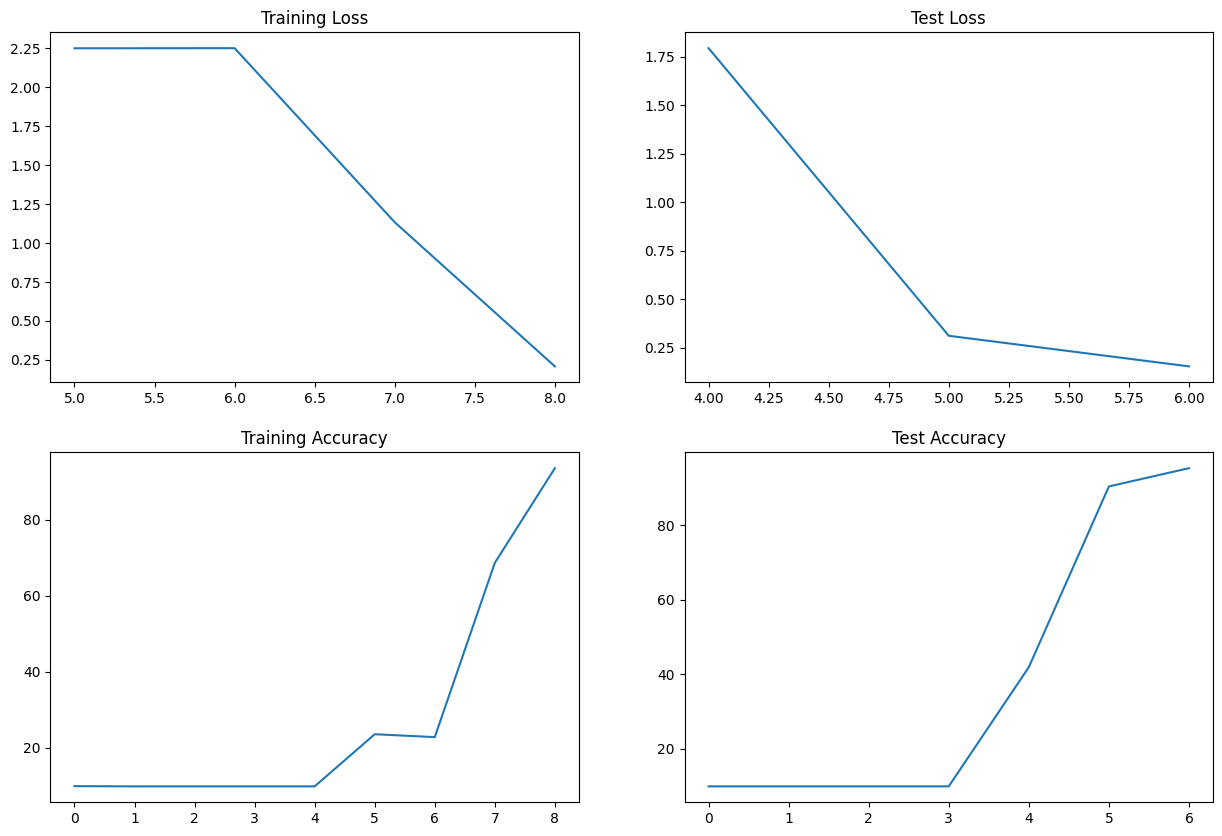

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
            Conv2d-2           [-1, 64, 24, 24]          18,432
            Conv2d-3          [-1, 128, 10, 10]          73,728
            Conv2d-4            [-1, 256, 8, 8]         294,912
            Linear-5                   [-1, 50]         204,800
            Linear-6                   [-1, 10]             500
Total params: 592,660
Trainable params: 592,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.93
----------------------------------------------------------------
